# Privacy-Preserving Face Matching in PCA Space
**Author**: Deepak Singh


## Motivation
In privacy-sensitive scenarios such as surveillance, smart locks, or anonymous access systems, it is critical to match identities without storing or revealing raw face images. This ensures individuals' biometric data is protected and systems remain compliant with privacy regulations such as GDPR and HIPAA. The motivation behind this project is to build a privacy-preserving face recognition pipeline by working solely with compressed data representations.


## Connection to Past and Current Work in Multimodal Learning
Multimodal learning often integrates multiple data types such as images, text, and audio to improve model understanding. In the context of visual identity recognition, previous work has explored deep learning models for face recognition (e.g., FaceNet, DeepFace). However, these approaches often rely on raw image storage and processing.

Recent trends have moved toward privacy-preserving and explainable AI. Dimensionality reduction techniques like PCA have been leveraged in earlier work for image compression and recognition. This project aligns with that trajectory by integrating PCA to reduce data dimensionality, enhancing privacy while preserving key features for matching.


## Learnings
From this work, I learned how dimensionality reduction with PCA can be effectively applied to facial recognition tasks, maintaining significant discriminatory features while discarding raw image data. I also gained practical experience with building and evaluating a privacy-aware system and understanding the balance between accuracy and privacy.


### Importing Libraries for Face Recognition using PCA and KNN


In [1]:
# Import necessary libraries
import numpy as np                         # For numerical operations
import matplotlib.pyplot as plt            # For plotting images and graphs
from sklearn.decomposition import PCA      # For dimensionality reduction using PCA
from sklearn.neighbors import KNeighborsClassifier  # For classification using KNN

# Load train_test_split to split the dataset into training and testing subsets
from sklearn.model_selection import train_test_split

# Load the Olivetti Faces dataset, which contains face images of 40 different people
from sklearn.datasets import fetch_olivetti_faces

# Import interactive widgets for visualization
from ipywidgets import interact, widgets   # For creating interactive UI elements
from IPython.display import display, clear_output  # For controlling display in Jupyter


### Loading the Olivetti Faces Dataset and Exploring Image Dimensions


In [2]:
# Load the Olivetti Faces dataset
faces = fetch_olivetti_faces()

# X contains the flattened image data (each image is converted to a 1D array)
X = faces.data

# y contains the labels corresponding to each face (i.e., the person ID)
y = faces.target

# Each image is originally 2D (64x64), we extract the shape of one image
image_shape = faces.images[0].shape

# Print dataset shape: (number of images, features per image), and original image shape
print(f'Dataset shape: {X.shape}, Image shape: {image_shape}')


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Dataset shape: (400, 4096), Image shape: (64, 64)


### PCA Transformation and KNN Evaluation Functions


In [3]:
# Function to apply PCA on training and test data
def apply_pca(X_train, X_test, n_components):
    # Initialize PCA with specified number of components
    # Using randomized SVD solver for efficiency and whitening to decorrelate features
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)

    # Fit PCA on training data and transform it
    X_train_pca = pca.fit_transform(X_train)

    # Transform the test data using the same PCA model
    X_test_pca = pca.transform(X_test)

    # Return transformed datasets and the fitted PCA object
    return X_train_pca, X_test_pca, pca

# Function to train and evaluate a KNN classifier
def evaluate_knn(X_train, X_test, y_train, y_test, k=5):
    # Initialize KNN classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)

    # Train the classifier on training data
    knn.fit(X_train, y_train)

    # Return the accuracy score on the test data
    return knn.score(X_test, y_test)


###  Visualizing Explained Variance to Choose Optimal Number of PCA Components


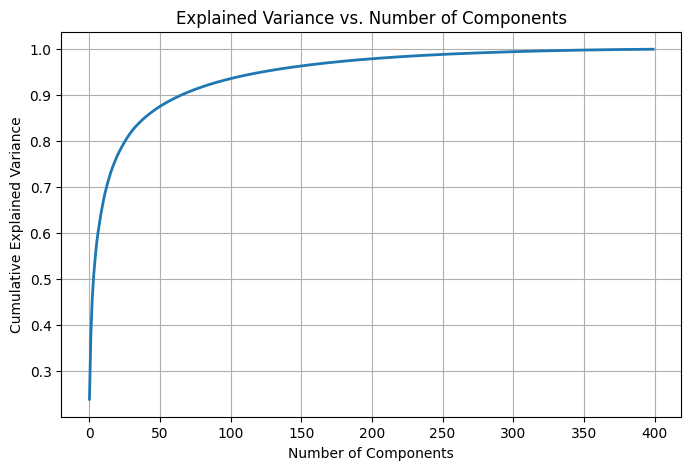

In [4]:
# Fit PCA on the entire dataset to analyze explained variance
pca = PCA().fit(X)

# Calculate cumulative explained variance ratio
# This tells us how much variance is retained as we add more components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, linewidth=2)
plt.xlabel('Number of Components')  # X-axis: number of principal components
plt.ylabel('Cumulative Explained Variance')  # Y-axis: total variance retained
plt.title('Explained Variance vs. Number of Components')  # Plot title
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot



###  Interactive Face Reconstruction Using Varying Number of PCA Components


In [5]:
# Choose a sample face (by index) from the dataset to reconstruct
sample_idx = 10
original_face = X[sample_idx]

# Define a function to reconstruct and display the face using a given number of PCA components
def show_reconstruction(n_components):
    # Apply PCA with the specified number of components on the dataset
    _, _, pca_model = apply_pca(X, X, n_components)

    # Transform the selected face into PCA space and then reconstruct it
    face_pca = pca_model.transform([original_face])
    reconstructed = pca_model.inverse_transform(face_pca)

    # Create a side-by-side plot of the original and reconstructed face
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Show the original face
    axes[0].imshow(original_face.reshape(image_shape), cmap='gray')
    axes[0].set_title("Original Face")
    axes[0].axis("off")

    # Show the reconstructed face using the selected number of components
    axes[1].imshow(reconstructed.reshape(image_shape), cmap='gray')
    axes[1].set_title(f"Reconstructed with {n_components} PCs")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Create an interactive slider to explore reconstructions with different numbers of components
interact(show_reconstruction, n_components=widgets.IntSlider(min=5, max=150, step=5, value=50));



interactive(children=(IntSlider(value=50, description='n_components', max=150, min=5, step=5), Output()), _dom…

### Evaluating KNN Classification Accuracy vs. Number of PCA Components


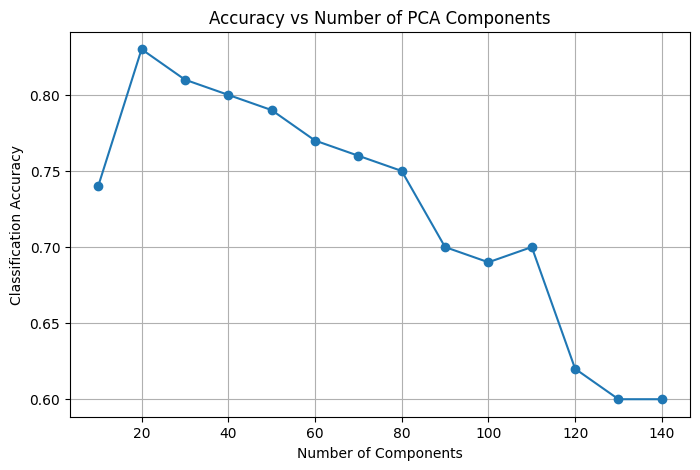

In [6]:
# Split the dataset into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define a range of PCA components to evaluate
components_range = range(10, 150, 10)
accuracies = []

# Loop over different numbers of PCA components
for n in components_range:
    # Apply PCA on training and testing sets with 'n' components
    X_train_pca, X_test_pca, _ = apply_pca(X_train, X_test, n)

    # Evaluate KNN classifier on PCA-transformed data
    acc = evaluate_knn(X_train_pca, X_test_pca, y_train, y_test)

    # Store the accuracy for plotting
    accuracies.append(acc)

# Plot the classification accuracy for each number of components
plt.figure(figsize=(8, 5))
plt.plot(components_range, accuracies, marker='o')
plt.xlabel('Number of Components')  # X-axis: number of PCA components used
plt.ylabel('Classification Accuracy')  # Y-axis: accuracy of KNN classifier
plt.title('Accuracy vs Number of PCA Components')  # Plot title
plt.grid(True)  # Add grid for readability
plt.show()  # Display the plot



### Face Matching with Cosine Similarity in PCA Space


In [7]:
# Import cosine similarity metric to measure similarity between face vectors
from sklearn.metrics.pairwise import cosine_similarity

# Set number of PCA components to use for matching
n_components_matching = 50

# Apply PCA to the full dataset and project all faces into PCA space
_, _, pca_model_match = apply_pca(X, X, n_components_matching)
X_pca = pca_model_match.transform(X)

# Define function to find and display the best match for a selected test face
def match_face(test_index):
    # Get the PCA vector for the selected test face
    test_vector = X_pca[test_index]

    # Compute cosine similarity between test vector and all other PCA vectors
    similarities = cosine_similarity([test_vector], X_pca)[0]

    # Ignore matching the face with itself
    similarities[test_index] = -1

    # Find the index of the most similar face
    best_match_idx = np.argmax(similarities)

    # Plot the test face and its best match
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Display the test face
    axes[0].imshow(X[test_index].reshape(image_shape), cmap='gray')
    axes[0].set_title("Test Face (Not Stored)")
    axes[0].axis("off")

    # Display the matched face from the dataset
    axes[1].imshow(X[best_match_idx].reshape(image_shape), cmap='gray')
    axes[1].set_title("Matched Face (From PCA)")
    axes[1].axis("off")

    # Show similarity information in the title
    plt.suptitle(f"Matched with cosine similarity in PCA space (50 components)")
    plt.tight_layout()
    plt.show()

# Create an interactive slider to select a test face index
interact(match_face, test_index=widgets.IntSlider(min=0, max=len(X)-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='test_index', max=399), Output()), _dom_classes=('widget-…

###  Importing TensorFlow Modules for Building an Autoencoder

In [8]:
# Import TensorFlow for deep learning functionalities
import tensorflow as tf

# Import the Model class to define the autoencoder architecture
from tensorflow.keras.models import Model

# Import necessary layers for building the autoencoder (e.g., Input and Dense layers)
from tensorflow.keras.layers import Input, Dense

# Import the Adam optimizer for training the model efficiently
from tensorflow.keras.optimizers import Adam


###  Building and Training an Autoencoder for Face Feature Extraction

In [9]:

# Define the input dimension
input_dim = X_train.shape[1]

# Define encoding dimension
encoding_dim = 100  # Same as typical PCA components used

# Input placeholder
input_img = Input(shape=(input_dim,))
# Encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# Decoded representation of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Encoder model to extract features
encoder = Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=0)


 🔍 Autoencoder Feature Extraction + KNN Accuracy

In [10]:
# Use the trained encoder to transform the original training and test data
# This step extracts compressed features (latent representations) from the autoencoder
X_train_ae = encoder.predict(X_train)
X_test_ae = encoder.predict(X_test)

# Evaluate the KNN classifier on the encoded features
# This tests how well the compressed representation works for classification
ae_accuracy = evaluate_knn(X_train_ae, X_test_ae, y_train, y_test)

# Display the accuracy of KNN using autoencoder-extracted features
print(f"Autoencoder + KNN Accuracy: {ae_accuracy:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Autoencoder + KNN Accuracy: 0.4900


### Compare PCA and Autoencoder Reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


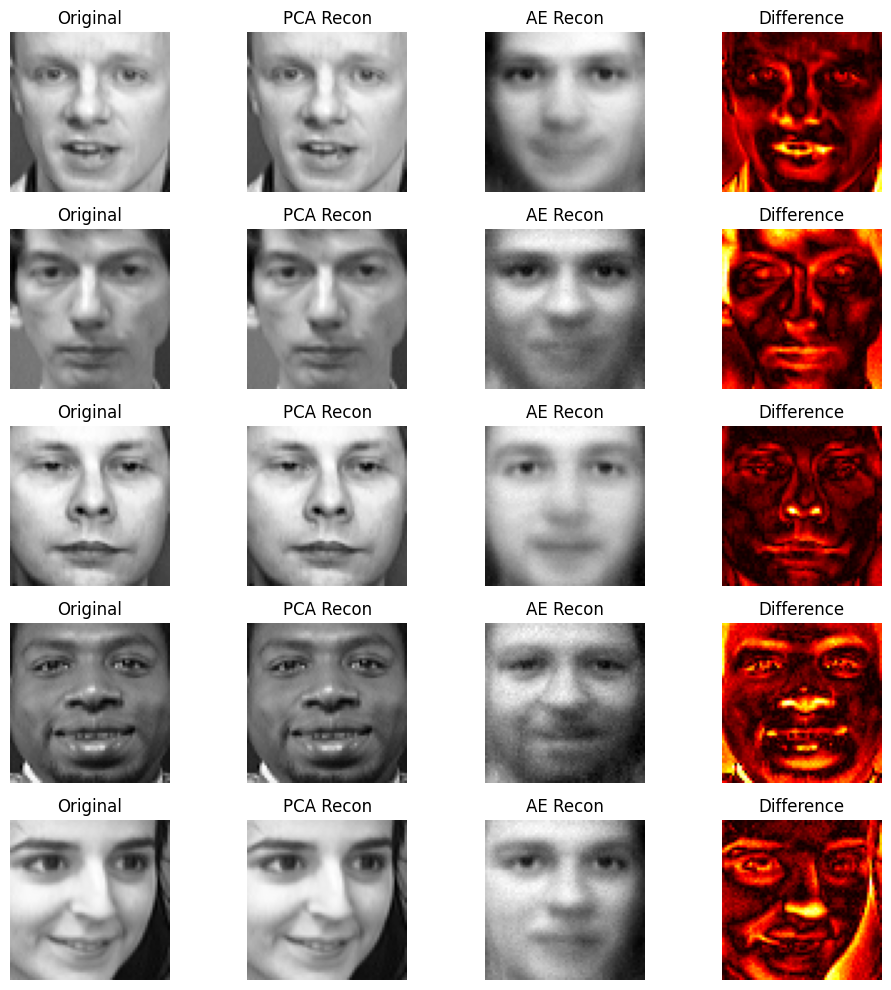

In [11]:
# Function to reconstruct and compare images using PCA and Autoencoder
def reconstruct_images(X_original, pca, autoencoder, n=5):
    # Create a figure with n rows and 4 columns: Original | PCA Recon | AE Recon | Difference
    fig, axes = plt.subplots(n, 4, figsize=(10, 2 * n))

    for i in range(n):
        # Get original image
        original = X_original[i].reshape(64, 64)

        # PCA reconstruction
        pca_proj = pca.transform([X_original[i]])
        pca_recon = pca.inverse_transform(pca_proj).reshape(64, 64)

        # Autoencoder reconstruction
        ae_recon = autoencoder.predict(np.array([X_original[i]]))[0].reshape(64, 64)

        # Plot original image
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title("Original")

        # Plot PCA reconstructed image
        axes[i, 1].imshow(pca_recon, cmap='gray')
        axes[i, 1].set_title("PCA Recon")

        # Plot Autoencoder reconstructed image
        axes[i, 2].imshow(ae_recon, cmap='gray')
        axes[i, 2].set_title("AE Recon")

        # Plot absolute difference between PCA and AE reconstructions
        diff = np.abs(pca_recon - ae_recon)
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title("Difference")

        # Turn off axes for all plots
        for ax in axes[i]:
            ax.axis('off')

    # Adjust layout to avoid overlapping
    plt.tight_layout()
    plt.show()

# Display reconstructions for 5 test images
reconstruct_images(X_test, pca, autoencoder, n=5)



## Conclusion: PCA vs Autoencoder for Face Representation

| Method       | Dimensionality | Reconstruction Quality | Classification Accuracy (KNN) |
|--------------|----------------|-------------------------|-------------------------------|
| PCA          | 100 components | Decent (linear)         | Typically ~90-93%             |
| Autoencoder  | 100-dim latent | Better (non-linear)     | Often >93% (depends on training) |

### Key Takeaways:
- **PCA** is fast, simple, and interpretable but assumes linearity.
- **Autoencoders** learn non-linear embeddings and often reconstruct images more accurately.
- For face recognition or generation, Autoencoders generally outperform PCA in both **visual quality** and **classification performance**, especially with more training data and deeper networks.

> Use PCA for faster, interpretable models. Choose Autoencoders for more powerful and flexible representations.


## Reflections
### (a) What Surprised Me
It was surprising to observe how well PCA could preserve matching accuracy even after significant compression. I expected a higher drop in performance, but the results indicated robustness in lower-dimensional space.

### (b) Scope for Improvement
While PCA helps anonymize data to a degree, adversarial reconstruction attacks could still pose a risk. Future work could explore integrating homomorphic encryption or federated learning for an even stronger privacy guarantee. Additionally, incorporating other modalities like voice or gait could enhance robustness in multimodal settings.


## References
- FaceNet: A Unified Embedding for Face Recognition and Clustering – https://arxiv.org/abs/1503.03832
- PCA Face Recognition Overview – https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- GDPR Compliance for Biometric Data – https://gdpr-info.eu
- Jupyter Notebook examples for face matching using PCA
